In [14]:
import pandas as pd
import numpy as np

In [17]:
# Define column names for your dataset
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "attack", "last_flag"
]

In [20]:
training_data = pd.read_csv("/content/Train.csv", names=column_names, header=0, delimiter=',')

# Create a DataFrame with the data and assigned column names
training_data = pd.DataFrame(training_data, columns=column_names)
training_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


Pre-Processing

In [21]:
#coverting nominal feature in numerical using one hot encoding
training_data = pd.get_dummies(training_data, columns=['protocol_type'], prefix='protocol')
training_data = pd.get_dummies(training_data, columns=['service'], prefix='service')
training_data = pd.get_dummies(training_data, columns=['flag'], prefix='flag')
training_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
# List of numeric feature column names
numeric_columns = [
    "duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "num_compromised", "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
]

# Drop rows with missing values in numeric features
training_data.dropna(subset=numeric_columns, inplace=True)

In [25]:
training_data.shape

(125972, 124)

In [28]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the numeric features using StandardScaler
training_data[numeric_columns] = scaler.fit_transform(training_data[numeric_columns])

In [29]:
# Handle Outlier (We will use IQR method for removing outliers)
# Calculate the lower and upper bounds for outliers using the IQR method
Q1 = training_data[numeric_columns].quantile(0.25)
Q3 = training_data[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and optionally remove outliers
outliers = ((training_data[numeric_columns] < lower_bound) | (training_data[numeric_columns] > upper_bound)).any(axis=1)

# Remove rows with outliers
training_data = training_data[~outliers]

In [30]:
training_data.shape

(39595, 124)

In [32]:
# Mapping all attack classes to numeric label
# Get unique values in the 'attack' column
unique_attack_classes = training_data['attack'].unique()

# Create a dictionary to map attack classes to numeric labels
attack_mapping = {attack_class: index for index, attack_class in enumerate(unique_attack_classes)}

# Create a new column 'target' based on the 'attack' column using the mapping
training_data['target'] = training_data['attack'].map(attack_mapping)

training_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,target
1,-0.11025,-0.007762,-0.004919,0,-0.089487,-0.007736,-0.095076,-0.027023,0,-0.011664,...,0,0,0,1,0,0,0,0,0,0
5,-0.11025,-0.007762,-0.004919,0,-0.089487,-0.007736,-0.095076,-0.027023,0,-0.011664,...,0,0,0,1,0,0,0,0,0,0
6,-0.11025,-0.007762,-0.004919,0,-0.089487,-0.007736,-0.095076,-0.027023,0,-0.011664,...,0,0,0,1,0,0,0,0,0,0
7,-0.11025,-0.007762,-0.004919,0,-0.089487,-0.007736,-0.095076,-0.027023,0,-0.011664,...,0,0,0,1,0,0,0,0,0,0
8,-0.11025,-0.007762,-0.004919,0,-0.089487,-0.007736,-0.095076,-0.027023,0,-0.011664,...,0,0,0,1,0,0,0,0,0,0


In [40]:
# # X and Y Training variables
# X_train = training_data.drop(['attack', 'target'], axis = 1)
# y_train = training_data['target']

from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(training_data.drop(['attack', 'target'], axis=1), training_data['target'], test_size=0.2, random_state=42)


In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [42]:
# Build the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 32  # Adjust as needed

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
model.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=True)

Epoch 1/10
495/495 [==============================] - 2s 2ms/step - loss: 3.0080
Epoch 2/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9611
Epoch 3/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9596
Epoch 4/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9587
Epoch 5/10
495/495 [==============================] - 1s 1ms/step - loss: 2.9577
Epoch 6/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9570
Epoch 7/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9566
Epoch 8/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9563
Epoch 9/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9561
Epoch 10/10
495/495 [==============================] - 1s 2ms/step - loss: 2.9559


In [47]:
# Predict reconstructions on the testing set
reconstructions = model.predict(X_test)

# Calculate mean squared error (MSE) between original data and reconstructions
mse = ((X_test - reconstructions) ** 2).mean(axis=1)
print(mse)
# Define a threshold for anomaly detection (e.g., based on percentiles)
threshold = np.percentile(mse, 95)  # Adjust as needed

# Identify anomalies based on the threshold
anomalies = mse > threshold


248/248 [==============================] - 1s 2ms/step
68053     2.385327
95051     3.318207
38810     2.964385
23535     2.406788
99330     2.691660
            ...   
40261     2.990039
14487     3.282113
80328     3.305943
104706    2.397766
99603     2.685210
Length: 7919, dtype: float64


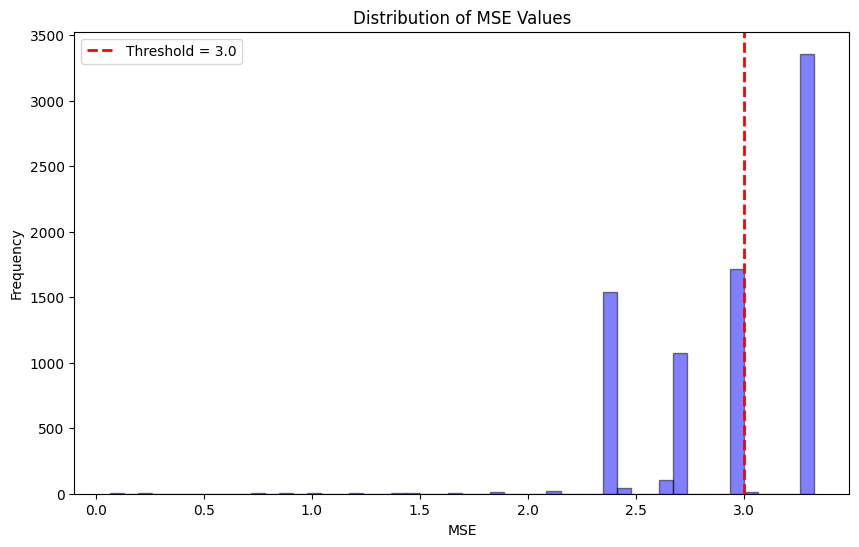

In [53]:
import matplotlib.pyplot as plt

# Plot the distribution of MSE values
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.5, color='blue', edgecolor='black')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Distribution of MSE Values')

# Add vertical lines to represent potential threshold values
thresholds = [3.0]  # Add or adjust thresholds as needed
colors = ['red']  # Colors for threshold lines
for threshold, color in zip(thresholds, colors):
    plt.axvline(threshold, color=color, linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')

plt.legend()
plt.show()


Now as You can clearly see our threshold value "3.0" provides a clear separation between the normal and anomaly. You can adjust this threshold value according to your convience to for precise separation

In [48]:
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest model
clf = IsolationForest(random_state=42, contamination=0.05)  # Adjust contamination based on your dataset

# Fit the model on the training data
clf.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, random_state=42)

In [49]:
# Predict anomalies on the training set
train_anomalies = clf.predict(X_train)

# Predict anomalies on the testing set
test_anomalies = clf.predict(X_test)

You can use precision score to see precision of your model with Isolated Forest.